In [1]:

from jax import config

config.update("jax_enable_x64", True)


In [22]:
from exojax.utils.grids import wavenumber_grid
from exojax.test.emulate_mdb import mock_mdb

mdb = mock_mdb("exomol")
N = 10000
nu_grid_right, _, _ = wavenumber_grid(4345.0, 4365.0, N, xsmode="premodit")
nu_grid_left, _, _ = wavenumber_grid(4325.0, 4345.0, N, xsmode="premodit")

nu_grid, _, _ = wavenumber_grid(4325.0, 4365.0, 2*N, xsmode="premodit")


xsmode =  modit
xsmode assumes ESLOG in wavenumber space: xsmode=modit
Your wavelength grid is in ***  ascending  *** order
The wavenumber grid is in ascending order by definition.
Please be careful when you use the wavelength grid.
HITRAN exact name= (12C)(16O)
radis engine =  vaex
Molecule:  CO
Isotopologue:  12C-16O
Background atmosphere:  H2
ExoMol database:  None
Local folder:  CO/12C-16O/SAMPLE
Transition files: 
	 => File 12C-16O__SAMPLE.trans
Broadening code level: a0
DataFrame (self.df) available.
xsmode =  premodit
xsmode assumes ESLOG in wavenumber space: xsmode=premodit
Your wavelength grid is in ***  descending  *** order
The wavenumber grid is in ascending order by definition.
Please be careful when you use the wavelength grid.
xsmode =  premodit
xsmode assumes ESLOG in wavenumber space: xsmode=premodit
Your wavelength grid is in ***  descending  *** order
The wavenumber grid is in ascending order by definition.
Please be careful when you use the wavelength grid.
xsmode =

/home/kawahara/exojax/src/exojax/spec/unitconvert.py:63: UserWarning: Both input wavelength and output wavenumber are in ascending order.
  warnings.warn(
/home/kawahara/exojax/src/exojax/spec/unitconvert.py:63: UserWarning: Both input wavelength and output wavenumber are in ascending order.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:197: FutureWarning: e2s will be replaced to exact_molname_exomol_to_simple_molname.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:91: FutureWarning: exojax.utils.molname.exact_molname_exomol_to_simple_molname will be replaced to radis.api.exomolapi.exact_molname_exomol_to_simple_molname.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:91: FutureWarning: exojax.utils.molname.exact_molname_exomol_to_simple_molname will be replaced to radis.api.exomolapi.exact_molname_exomol_to_simple_molname.
  warnings.warn(
/home/kawahara/anaconda3/lib/python3.10/site-packages/radis-0.15.2-py3.10.egg/radis/api

In [25]:
from exojax.spec.opacalc import OpaPremodit

T=1000.0 #K
P=1.0 #bar

opa_close_right = OpaPremodit(
    mdb=mdb,
    nu_grid=nu_grid_right,
    dit_grid_resolution=0.2,
    auto_trange=[400.0, 1500.0],
    alias="close",
)
xsv_close_right = opa_close_right.xsvector(T,P)

opa_close_left = OpaPremodit(
    mdb=mdb,
    nu_grid=nu_grid_left,
    dit_grid_resolution=0.2,
    auto_trange=[400.0, 1500.0],
    alias="close",
)
xsv_close_left = opa_close_left.xsvector(T,P)


opa_close_all = OpaPremodit(
    mdb=mdb,
    nu_grid=nu_grid,
    dit_grid_resolution=0.2,
    auto_trange=[400.0, 1500.0],
    alias="close",
)
xsv_close_all= opa_close_all.xsvector(T,P)



/home/kawahara/exojax/src/exojax/spec/opacalc.py:269: UserWarning: dit_grid_resolution is not None. Ignoring broadening_parameter_resolution.
  warnings.warn(
/home/kawahara/exojax/src/exojax/spec/initspec.py:280: UserWarning: Some of the line centers are outside of the wavenumber grid.
  warnings.warn(
/home/kawahara/exojax/src/exojax/spec/initspec.py:282: UserWarning: All of the line center should be within wavenumber grid for PreMODIT/MODIT/DIT.
  warnings.warn(


OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 393.5569458240504 - 1647.2060977798956 K
OpaPremodit: Tref_broadening is set to  774.5966692414833 K
# of reference width grid :  3
# of temperature exponent grid : 2


uniqidx: 100%|██████████| 2/2 [00:00<00:00, 4181.76it/s]
/home/kawahara/exojax/src/exojax/spec/opacalc.py:269: UserWarning: dit_grid_resolution is not None. Ignoring broadening_parameter_resolution.
  warnings.warn(
/home/kawahara/exojax/src/exojax/spec/initspec.py:280: UserWarning: Some of the line centers are outside of the wavenumber grid.
  warnings.warn(
/home/kawahara/exojax/src/exojax/spec/initspec.py:282: UserWarning: All of the line center should be within wavenumber grid for PreMODIT/MODIT/DIT.
  warnings.warn(


Premodit: Twt= 457.65619999186345 K Tref= 1108.1485374361412 K
Making LSD:|####################| 100%
cross section (xsvector/xsmatrix) is calculated in the closed mode. The aliasing part cannnot be used.
OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 393.5569458240504 - 1647.2060977798956 K
OpaPremodit: Tref_broadening is set to  774.5966692414833 K
# of reference width grid :  3
# of temperature exponent grid : 2


uniqidx: 100%|██████████| 1/1 [00:00<00:00, 14563.56it/s]


Premodit: Twt= 457.65619999186345 K Tref= 1108.1485374361412 K
Making LSD:|####################| 100%


/home/kawahara/exojax/src/exojax/spec/opacalc.py:269: UserWarning: dit_grid_resolution is not None. Ignoring broadening_parameter_resolution.
  warnings.warn(


cross section (xsvector/xsmatrix) is calculated in the closed mode. The aliasing part cannnot be used.
OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 393.5569458240504 - 1647.2060977798956 K
OpaPremodit: Tref_broadening is set to  774.5966692414833 K
# of reference width grid :  3
# of temperature exponent grid : 2


uniqidx: 100%|██████████| 2/2 [00:00<00:00, 16320.25it/s]


Premodit: Twt= 457.65619999186345 K Tref= 1108.1485374361412 K
Making LSD:|####################| 100%
cross section (xsvector/xsmatrix) is calculated in the closed mode. The aliasing part cannnot be used.


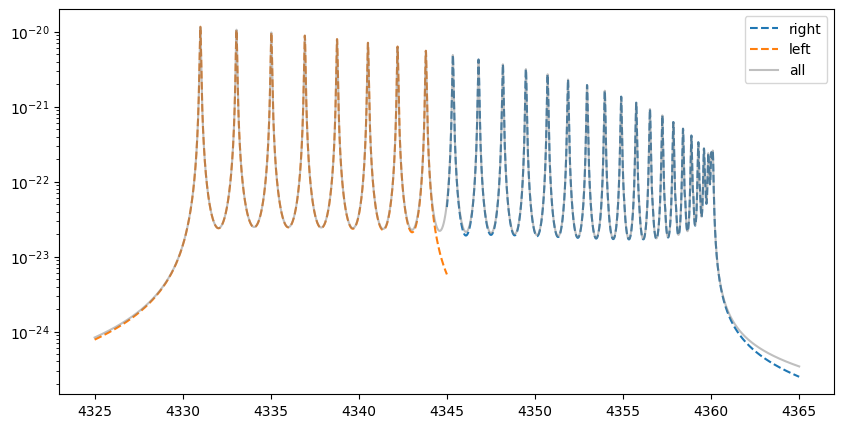

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 5))
plt.plot(nu_grid_right, xsv_close_right, ls="--", label="right")
plt.plot(nu_grid_left, xsv_close_left, ls="--", label="left")
plt.plot(nu_grid, xsv_close_all,alpha=0.5, color="gray", label="all")
plt.yscale("log")
plt.legend()
plt.show()

In [32]:
opa_open_right = OpaPremodit(
    mdb=mdb,
    nu_grid=nu_grid_right,
    dit_grid_resolution=0.2,
    auto_trange=[400.0, 1500.0],
    alias="open",
    cutwing=1.0,
)
xsv_open_right = opa_open_right.xsvector(T,P)

opa_open_left = OpaPremodit(
    mdb=mdb,
    nu_grid=nu_grid_left,
    dit_grid_resolution=0.2,
    auto_trange=[400.0, 1500.0],
    alias="open",
    cutwing=1.0,
)
xsv_open_left = opa_open_left.xsvector(T,P)

opa_open_all = OpaPremodit(
    mdb=mdb,
    nu_grid=nu_grid,
    dit_grid_resolution=0.2,
    auto_trange=[400.0, 1500.0],
    alias="open",
    cutwing=1.0,
)
xsv_open_all= opa_open_all.xsvector(T,P)

/home/kawahara/exojax/src/exojax/spec/opacalc.py:269: UserWarning: dit_grid_resolution is not None. Ignoring broadening_parameter_resolution.
  warnings.warn(
/home/kawahara/exojax/src/exojax/spec/initspec.py:280: UserWarning: Some of the line centers are outside of the wavenumber grid.
  warnings.warn(
/home/kawahara/exojax/src/exojax/spec/initspec.py:282: UserWarning: All of the line center should be within wavenumber grid for PreMODIT/MODIT/DIT.
  warnings.warn(


OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 393.5569458240504 - 1647.2060977798956 K
OpaPremodit: Tref_broadening is set to  774.5966692414833 K
# of reference width grid :  3
# of temperature exponent grid : 2


uniqidx: 100%|██████████| 2/2 [00:00<00:00, 14716.86it/s]

Premodit: Twt= 457.65619999186345 K Tref= 1108.1485374361412 K
Making LSD:|####################| 100%
cross section (xsvector/xsmatrix) is calculated in the open mode. The aliasing part can be used.


/home/kawahara/exojax/src/exojax/spec/opacalc.py:269: UserWarning: dit_grid_resolution is not None. Ignoring broadening_parameter_resolution.
  warnings.warn(
/home/kawahara/exojax/src/exojax/spec/initspec.py:280: UserWarning: Some of the line centers are outside of the wavenumber grid.
  warnings.warn(
/home/kawahara/exojax/src/exojax/spec/initspec.py:282: UserWarning: All of the line center should be within wavenumber grid for PreMODIT/MODIT/DIT.
  warnings.warn(


OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 393.5569458240504 - 1647.2060977798956 K
OpaPremodit: Tref_broadening is set to  774.5966692414833 K
# of reference width grid :  3
# of temperature exponent grid : 2


uniqidx: 100%|██████████| 1/1 [00:00<00:00, 1902.18it/s]


Premodit: Twt= 457.65619999186345 K Tref= 1108.1485374361412 K
Making LSD:|####################| 100%
cross section (xsvector/xsmatrix) is calculated in the open mode. The aliasing part can be used.


/home/kawahara/exojax/src/exojax/spec/opacalc.py:269: UserWarning: dit_grid_resolution is not None. Ignoring broadening_parameter_resolution.
  warnings.warn(


OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 393.5569458240504 - 1647.2060977798956 K
OpaPremodit: Tref_broadening is set to  774.5966692414833 K
# of reference width grid :  3
# of temperature exponent grid : 2


uniqidx: 100%|██████████| 2/2 [00:00<00:00, 4177.59it/s]


Premodit: Twt= 457.65619999186345 K Tref= 1108.1485374361412 K
Making LSD:|####################| 100%
cross section (xsvector/xsmatrix) is calculated in the open mode. The aliasing part can be used.


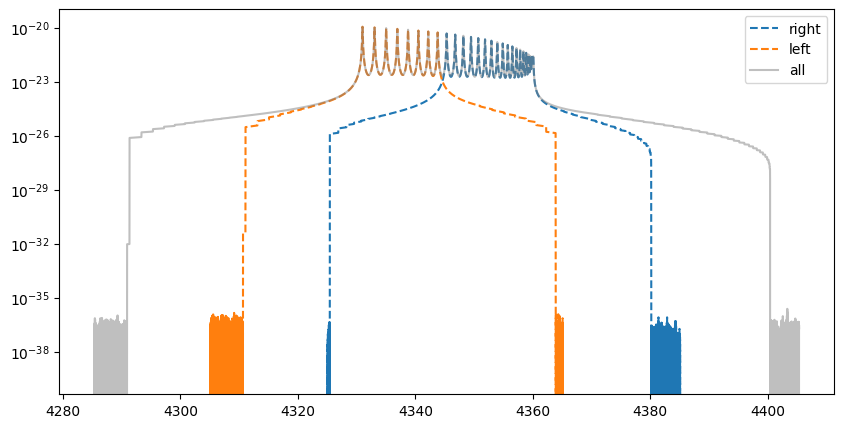

In [34]:

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 5))
plt.plot(opa_open_right.nu_grid_extended, xsv_open_right, ls="--", label="right")
plt.plot(opa_open_left.nu_grid_extended, xsv_open_left, ls="--", label="left")
plt.plot(opa_open_all.nu_grid_extended, xsv_open_all,alpha=0.5, color="gray", label="all")
plt.yscale("log")
plt.legend()
plt.show()

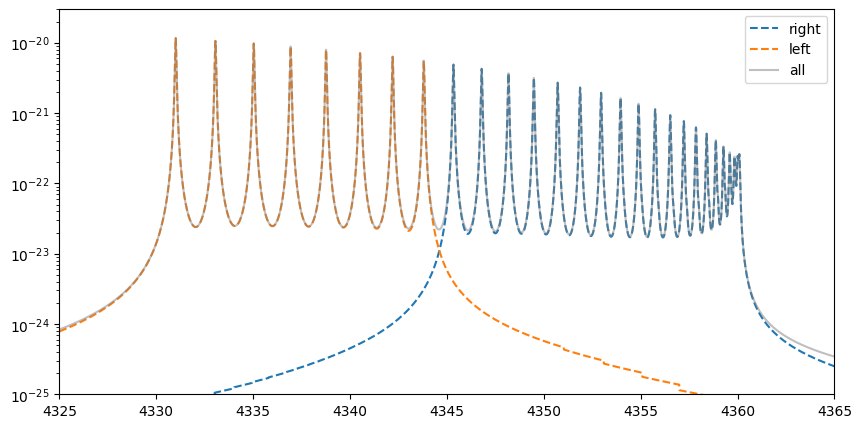

In [37]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 5))
plt.plot(opa_open_right.nu_grid_extended, xsv_open_right, ls="--", label="right")
plt.plot(opa_open_left.nu_grid_extended, xsv_open_left, ls="--", label="left")
plt.plot(opa_open_all.nu_grid_extended, xsv_open_all,alpha=0.5, color="gray", label="all")
plt.yscale("log")
plt.xlim(nu_grid[0],nu_grid[-1])
plt.ylim(1.0e-25,3.0e-20)
plt.legend()
plt.show()